In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight


In [13]:
# 1. Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
train_dir = '../../data5/train'
test_dir  = '../../data5/test'

# 2. Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())
print("Classes:", class_labels)

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Classes: ['Acne', 'Eczema', 'Infection', 'Malignant']


In [14]:
# Standalone ResNet50 Model
def build_resnet50_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in resnet_base.layers[:-30]:
        layer.trainable = False
    for layer in resnet_base.layers[-30:]:
        layer.trainable = True
    input_tensor = Input(shape=(224, 224, 3))
    x = resnet_base(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=l2(1e-4)  # small weight decay
    )(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_resnet50_model(num_classes)

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=1000, alpha=0.00001
)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,777,348 (94.52 MB)

 Trainable params: 15,635,716 (59.65 MB)

 Non-trainable params: 9,141,632 (34.87 MB)

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the trained model
model.save("../../models/hybrid_model_cnn_rf.keras")

Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.6107 - loss: 1.1391 - val_accuracy: 0.5633 - val_loss: 32.0015 - learning_rate: 9.1530e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 770s 4s/step - accuracy: 0.7206 - loss: 0.7741 - val_accuracy: 0.7457 - val_loss: 0.6446 - learning_rate: 6.8989e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 764s 4s/step - accuracy: 0.7768 - loss: 0.5809 - val_accuracy: 0.7857 - val_loss: 0.5579 - learning_rate: 4.0015e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.8125 - loss: 0.4813 - val_accuracy: 0.8106 - val_loss: 0.4965 - learning_rate: 1.4424e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 743s 4s/step - accuracy: 0.8377 - loss: 0.4207 - val_accuracy: 0.8152 - val_loss: 0.4958 - learning_rate: 8.8663e-06
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 745s 4s/step - accuracy: 0.8516 - loss: 0.3842 - val_accuracy: 0.8144 - val_loss: 0.5002 - learning_rate: 1.0000e-08
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 748s 4s/step - accuracy: 0.8

In [16]:
for layer in model.layers[:-30]:
    layer.trainable = False
for layer in model.layers[-30:]:
    layer.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tune the Model
history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 764s 4s/step - accuracy: 0.8475 - loss: 0.3946 - val_accuracy: 0.8141 - val_loss: 0.5007 - learning_rate: 1.0000e-05
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.8589 - loss: 0.3752 - val_accuracy: 0.8148 - val_loss: 0.5022 - learning_rate: 1.0000e-05
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 760s 4s/step - accuracy: 0.8672 - loss: 0.3519 - val_accuracy: 0.8156 - val_loss: 0.5033 - learning_rate: 1.0000e-05
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 746s 4s/step - accuracy: 0.8527 - loss: 0.3635 - val_accuracy: 0.8175 - val_loss: 0.5011 - learning_rate: 1.0000e-05
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 740s 4s/step - accuracy: 0.8597 - loss: 0.3652 - val_accuracy: 0.8179 - val_loss: 0.5018 - learning_rate: 1.0000e-05
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 741s 4s/step - accuracy: 0.8571 - loss: 0.4034 - val_accuracy: 0.8203 - val_loss: 0.4952 - learning_rate: 1.0000e-05
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 748s 4s/step - acc

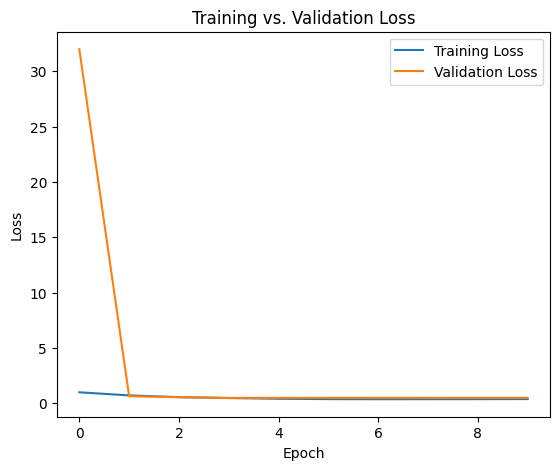

In [17]:
# 5. Plot Training vs. Validation Curves
plt.figure(figsize=(14, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


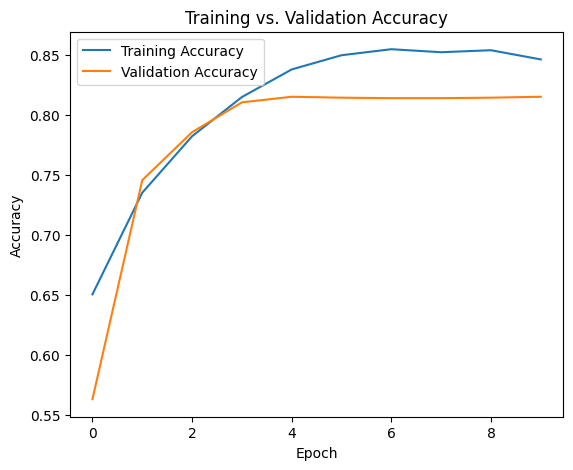

In [18]:
plt.figure(figsize=(14, 5))
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


81/81 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.8455 - loss: 0.4814
Test Loss: 0.4931313097476959
compile_metrics: 0.8276397585868835
81/81 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.91      0.88      0.89       626
      Eczema       0.78      0.80      0.79       650
   Infection       0.70      0.76      0.73       650
   Malignant       0.96      0.87      0.91       650

    accuracy                           0.83      2576
   macro avg       0.84      0.83      0.83      2576
weighted avg       0.83      0.83      0.83      2576

Confusion Matrix:
 [[551  16  54   5]
 [ 18 521 105   6]
 [ 27 112 497  14]
 [ 12  17  58 563]]
Macro-average ROC AUC: 0.9577263671041103
Micro-average ROC AUC: 0.9620622616957936


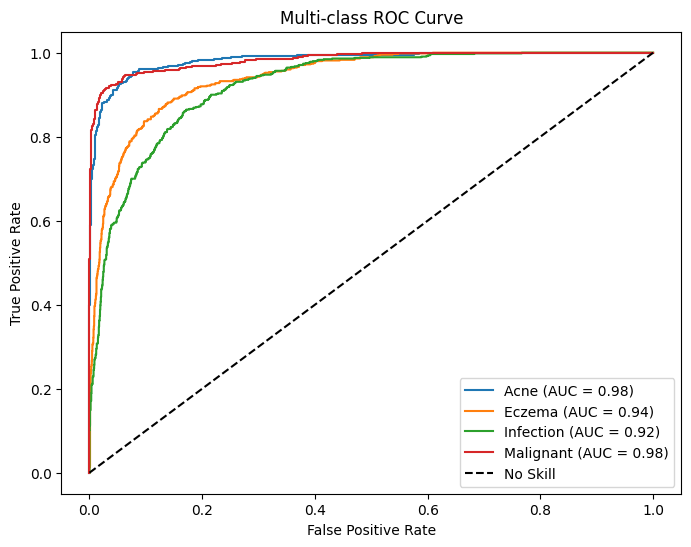

In [19]:
test_metrics = model.evaluate(test_generator)
print(f"Test Loss: {test_metrics[0]}")
for idx, metric_name in enumerate(model.metrics_names[1:], start=1):
    print(f"{metric_name}: {test_metrics[idx]}")


# 7. Classification Report & Confusion Matrix
y_pred_probs = model.predict(test_generator)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_true_indices = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))

cm = confusion_matrix(y_true_indices, y_pred_indices)
print("Confusion Matrix:\n", cm)

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

81/81 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8455 - loss: 0.4814
Val Loss: 0.4931313097476959
Val Accuracy: 0.8276397585868835


In [21]:
# 6. Evaluate on Test Set
results = model.evaluate(train_generator)
print("Train Loss:", results[0])
print("Train Accuracy:", results[1])

188/188 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9074 - loss: 0.2684
Train Loss: 0.26110079884529114
Train Accuracy: 0.9096516370773315


In [24]:
model.save("../../models/hybrid_model_train_resnet.keras")

In [25]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Constants
BATCH_SIZE = 32  # Replace with your actual batch size
MODEL_SAVE_PATH = '../../models/hybrid_rf_res_model_7030.pkl'  # Path to save the model

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        features.append(base_model.predict(batch_images, verbose=0))  # Extract features
        labels.append(batch_labels)
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break
    features = np.vstack(features)  # Stack features vertically
    labels = np.vstack(labels)      # Stack labels vertically
    return features, labels

# Step 1: Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, model, BATCH_SIZE)

# Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, model, BATCH_SIZE)

# Step 2: Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Step 3: Flatten Features for Random Forest
print("Flattening features for Random Forest...")
X_train = train_features.reshape(train_features.shape[0], -1)
X_test = test_features.reshape(test_features.shape[0], -1)

# Step 4: Define and Train Random Forest with Grid Search
print("Training Random Forest with Grid Search...")
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, train_labels)

# Get the best model from grid search
best_rf = grid_search.best_estimator_

# Step 5: Evaluate the Model
print("Evaluating the model...")
y_pred = best_rf.predict(X_test)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# Step 6: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
Flattening features for Random Forest...
Training Random Forest with Grid Search...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       626
           1       0.80      0.75      0.78       650
           2       0.68      0.79      0.73       650
           3       0.94      0.89      0.92       650

    accuracy                           0.83      2576
   macro avg       0.84      0.83      0.83      2576
weighted avg       0.83      0.83      0.83      2576

Confusion Matrix:
[[549  13  55   9]
 [ 19 488 132  11]
 [ 27  94 514  15]
 [  8  12  51 579]]
Saving the model to ../../models/hybrid_rf_vgg16_model_7030.pkl...
Model saved successfully.


Confusion Matrix:
[[549  13  55   9]
 [ 19 488 132  11]
 [ 27  94 514  15]
 [  8  12  51 579]]


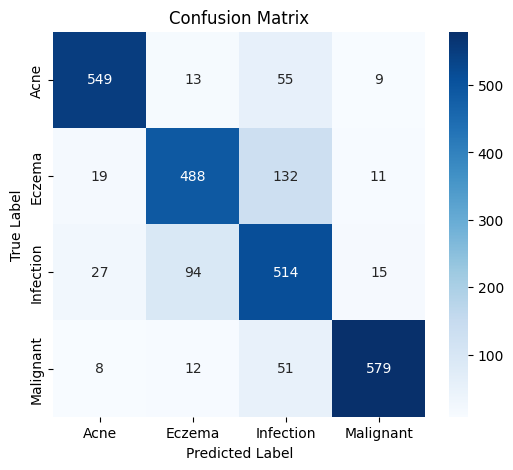

In [26]:
import seaborn as sns
cm = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()